# CNN Baseline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and Helper Functions

In [2]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.6 MB/s eta 0:00:00


In [3]:
!pip install -q gensim==3.8.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 67.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 42.6 MB/s eta 0:00:00


In [6]:
pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd


from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_text as tf_text
import tensorflow_addons as tfa

import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib as mpl
import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Below is a helper function to plot histories.

In [7]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              # model_history2, 
              model_1_name='model 1',
              # model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy', 'f1_score']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        # y_lim_lower2 = np.min(model_history2.history[metric])
        # y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9
        y_lim_lower = y_lim_lower1

        y_lim_upper1 = np.max(model_history1.history[metric])
        # y_lim_upper2 = np.max(model_history2.history[metric])
        # y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1
        y_lim_upper = y_lim_upper1

        # for j, model_history in enumerate([model_history1, model_history2]):
        for j, model_history in enumerate([model_history1]):
            model_name = [model_1_name][j]
            # ax1 = axs[i, j]
            ax1 = axs[i]
            ax1.plot(model_history.history[metric], marker='o')
            ax1.plot(model_history.history['val_%s' % metric], marker='o')
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

## Load data

In [10]:
disability_df_train = pd.read_csv('drive/MyDrive/data/disability-dataset-train-augmented.csv')
disability_df_val = pd.read_csv('drive/MyDrive/data/disability-dataset-val-augmented.csv')
disability_df_test = pd.read_csv('drive/MyDrive/data/disability-dataset-test-augmented.csv')

# Form tensors of labels and features.
disability_train_labels = tf.convert_to_tensor(disability_df_train['toxicity_binary'])
disability_val_labels = tf.convert_to_tensor(disability_df_val['toxicity_binary'])
disability_test_labels = tf.convert_to_tensor(disability_df_test['toxicity_binary'])

disability_train_examples = tf.convert_to_tensor(disability_df_train['comment_text'])
disability_val_examples = tf.convert_to_tensor(disability_df_val['comment_text'])
disability_test_examples = tf.convert_to_tensor(disability_df_test['comment_text'])

In [11]:
len(disability_df_train)/(len(disability_df_train)+len(disability_df_test)+len(disability_df_val))

0.6856639409707882

In [17]:
disability_train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b' ( so far )\n- ( so far )\n- (so far )\n- ( so far )\n- ( so far )\n-',
       b' mental disability is extremely physical',
       b'Many school related studies focus on the work on children with disabilities in school.\n[6] This article talks about the exceptional children in the classroom and',
       b' could also be labeled-\n- at its heart, mental disability is a financial issue'],
      dtype=object)>

In [18]:
disability_train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 1, 0, 1])>

Next, we tokenize the data:

In [19]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(disability_train_examples)
val_tokens = tokenizer.tokenize(disability_val_examples)
test_tokens = tokenizer.tokenize(disability_test_examples)

Does this look right?

In [20]:
train_tokens[0]

<tf.Tensor: shape=(24,), dtype=string, numpy=
array([b'(', b'so', b'far', b')', b'-', b'(', b'so', b'far', b')', b'-',
       b'(so', b'far', b')', b'-', b'(', b'so', b'far', b')', b'-', b'(',
       b'so', b'far', b')', b'-'], dtype=object)>

# Word2Vec

Next, we get the word2vec model from nltk.

In [21]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [22]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [23]:
len(model.vocab)

43981

How do the word vectors look like? As expected:

In [24]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [25]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [26]:
embedding_matrix.shape

(43982, 300)

In [27]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

## Data preparation
For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [28]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.

In [29]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [30]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)
val_input = docs_to_vocab_ids(val_tokens)

train_labels = np.array(disability_train_labels)
val_labels = np.array(disability_val_labels)
test_labels = np.array(disability_test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Total examples:  24903
Examples processed:  0
Examples processed:  5000
Total examples:  7264
Examples processed:  0
Total examples:  4151


In [31]:
train_input[:2]

array([[43981, 22793, 42591, 43981, 43981, 43981, 22793, 42591, 43981,
        43981, 43981, 42591, 43981, 43981, 43981, 22793, 42591, 43981,
        43981, 43981, 22793, 42591, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [32]:
train_labels[:4]

array([1, 1, 0, 1])

## CNN Model
Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [33]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)
    cnn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy',f1_score])
#     cnn_model.compile(optimizer='adam',
#                       loss='binary_crossentropy',  # From information theory notebooks.
#                       metrics=['accuracy',f1_score])
    return cnn_model

In [34]:
# Now specify model hyperparameters and call the function to create a CNN model

# # From class notebook
# num_filters = [100, 100, 50, 25]
# kernel_sizes = [3, 4, 5, 10]
# dense_layer_dims = [100, 50]
# dropout_rate = 0.5

# From CNN paper: https://arxiv.org/pdf/1408.5882.pdf
# filter windows (h) of 3, 4, 5 with 100 feature maps each,
# dropout rate (p) of 0.5, l2 constraint (s) of 3, and
# mini-batch size of 50.
num_filters = [100, 100, 100]
kernel_sizes = [3, 4, 5]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [35]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     13194600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 126, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 125, 100)     120100      ['embedding[0][0]']              
                                                                                              

In [36]:
neg, pos = np.bincount(disability_df_train['toxicity_binary'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Weight for class 0: 1.05
Weight for class 1: 0.96


In [37]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(val_input, val_labels),
                            batch_size=20,
                            epochs=10,
                            class_weight=class_weight
                            )

Epoch 1/10
1246/1246 [==============================] - 16s 5ms/step - loss: 0.6974 - accuracy: 0.5311 - f1_score: 0.3694 - val_loss: 0.6642 - val_accuracy: 0.6414 - val_f1_score: 0.6839
Epoch 2/10
1246/1246 [==============================] - 6s 5ms/step - loss: 0.6539 - accuracy: 0.6436 - f1_score: 0.6518 - val_loss: 0.6218 - val_accuracy: 0.7028 - val_f1_score: 0.7244
Epoch 3/10
1246/1246 [==============================] - 6s 4ms/step - loss: 0.6155 - accuracy: 0.6874 - f1_score: 0.6942 - val_loss: 0.5846 - val_accuracy: 0.7218 - val_f1_score: 0.7219
Epoch 4/10
1246/1246 [==============================] - 6s 4ms/step - loss: 0.5844 - accuracy: 0.7099 - f1_score: 0.7130 - val_loss: 0.5571 - val_accuracy: 0.7295 - val_f1_score: 0.7358
Epoch 5/10
1246/1246 [==============================] - 6s 4ms/step - loss: 0.5596 - accuracy: 0.7208 - f1_score: 0.7228 - val_loss: 0.5397 - val_accuracy: 0.7416 - val_f1_score: 0.7454
Epoch 6/10
1246/1246 [==============================] - 5s 4ms/step -

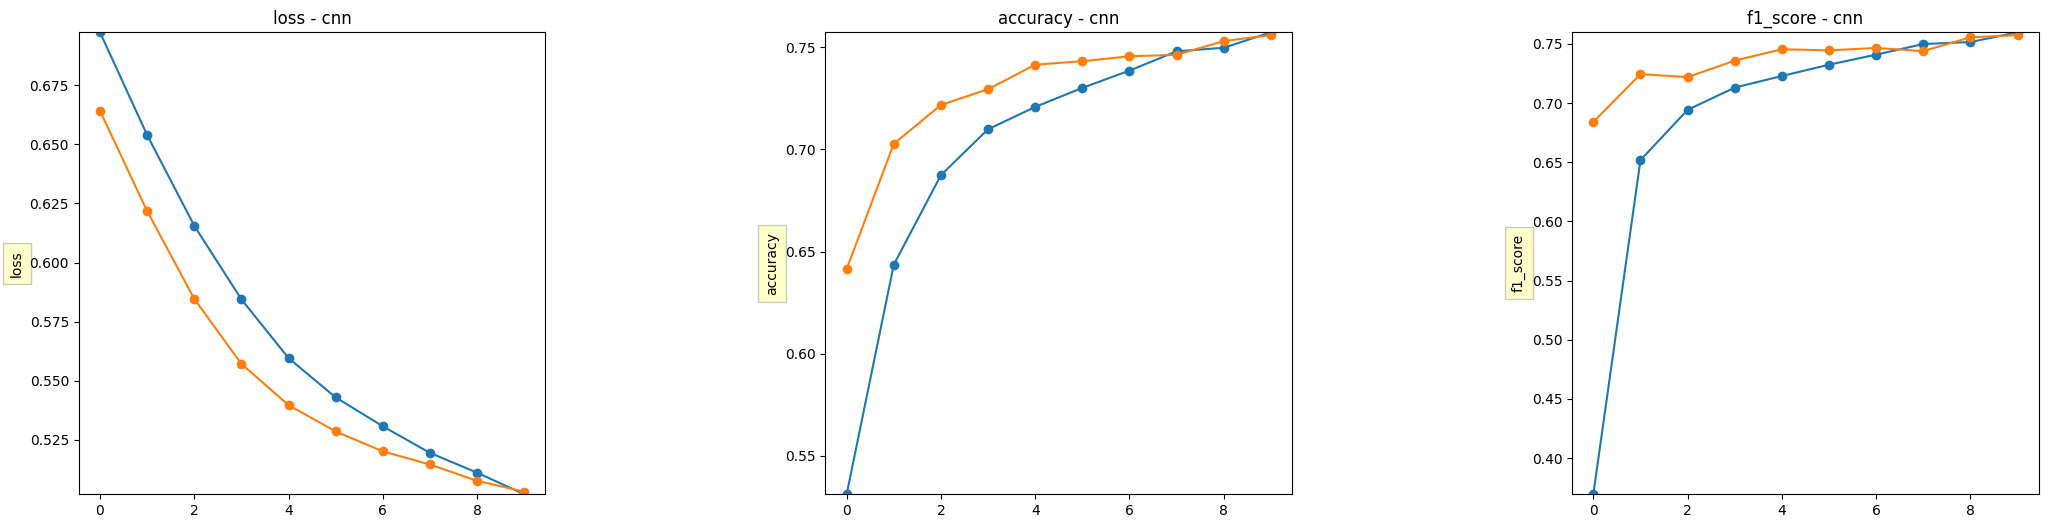

In [38]:
fig, axs = plt.subplots(1, 3)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          model_1_name='cnn')

fig.align_ylabels(axs[1])
fig.set_size_inches(28, 6)
plt.show()

# Save CNN Model

In [39]:
cnn_model.save("drive/MyDrive/model_checkpoints/cnn_disability_model.keras")

In [40]:
# Test loading model
cnn_loaded_model = tf.keras.models.load_model("drive/MyDrive/model_checkpoints/cnn_disability_model.keras")
cnn_loaded_model_history = cnn_loaded_model.evaluate(test_input, test_labels)

228/228 [==============================] - 1s 4ms/step - loss: 0.4838 - accuracy: 0.7715 - f1_score: 0.7741


## Previous Results

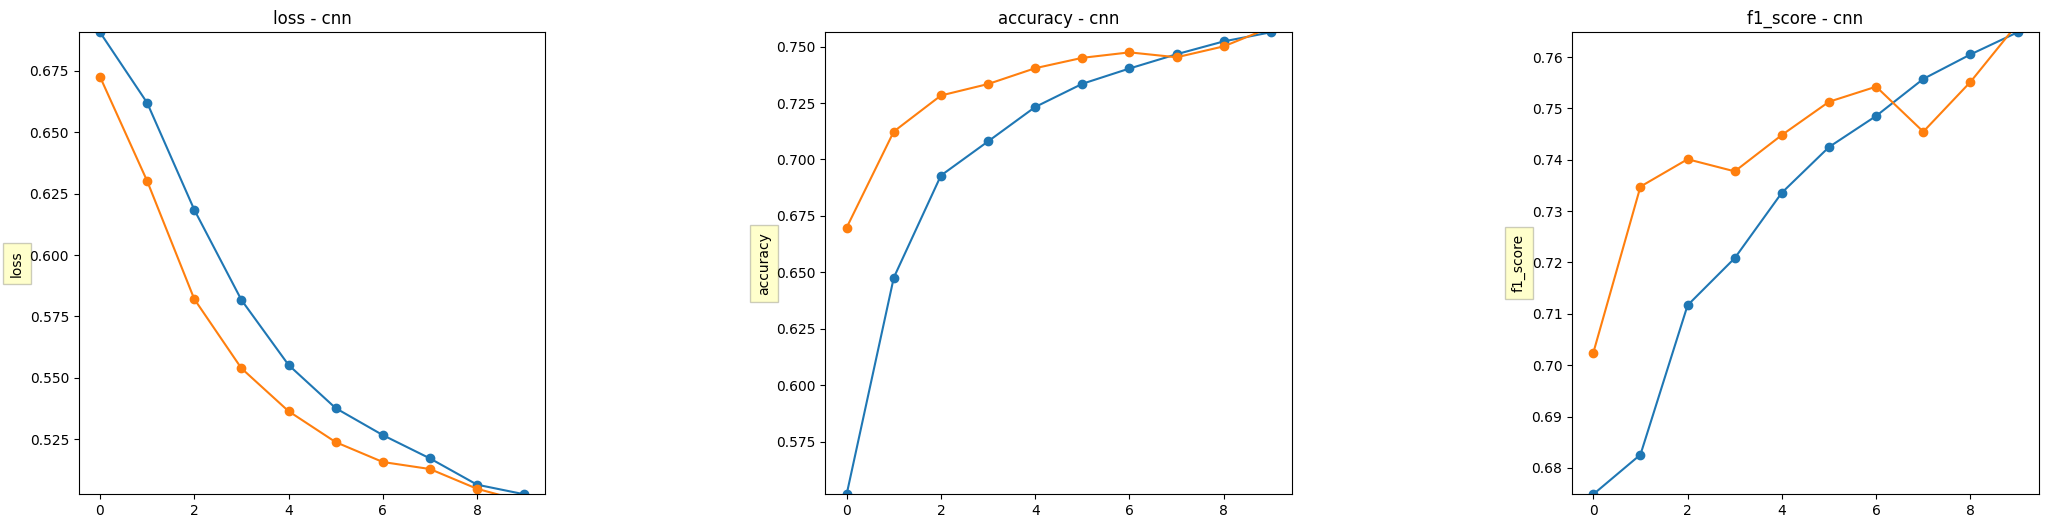

In [ ]:
# PREVIOUS RESULT - DON'T RUN THIS CELL
# fig, axs = plt.subplots(1, 3)
# fig.subplots_adjust(left=0.2, wspace=0.6)
# make_plot(axs,
#           cnn_history,
#           model_1_name='cnn')

# fig.align_ylabels(axs[1])
# fig.set_size_inches(28, 6)
# plt.show()